# Model Evaluation and Interpretation

In [11]:
from fastai.text import *
from fastai.lm_rnn import *
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import html

TWEETSLM_PATH=Path('./LM_tweets_best')
CLAS_PATH=Path('./tweets_class')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

# helper functions

In [12]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

# tokenize and classify

In [13]:
chunksize=24000
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)
tst_tok, tst_lbls = get_all(df_tst, 1)

itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

tst_ids = np.array([[stoi[o] for o in p] for p in tst_tok])
tst_lbls = np.array(tst_lbls)

bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

c=int(tst_lbls.max())
tst_ds = TextDataset(tst_ids, tst_lbls)
tst_samp = SortSampler(tst_ids, key=lambda x: len(tst_ids[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)+1

# results

In [17]:
type((tst_lbls_sampled == predictions)

numpy.ndarray

F1(macro) =  0.7026971368599696
Accuracy  =  0.24285009861932938


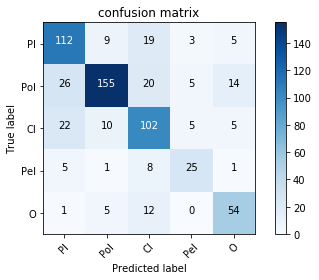

In [14]:
f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)

cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()

F1(macro) =  0.7026971368599696
Accuracy  =  0.717948717948718


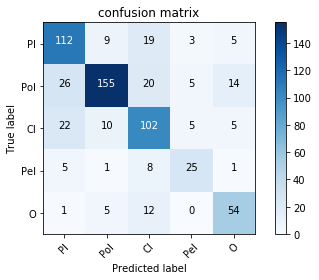

In [15]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
tst_lbls -= tst_lbls.min()
c=int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()

# EDA

In [5]:
df = pd.DataFrame({'tokens':[" ".join(sen) for sen in tst_tok], 
                   'actual':tst_lbls.flatten() , 
                   'prediction': predictions})

In [6]:
print_full(df.loc[df['actual']!=df['prediction']]['tokens'])

0      \n xbos rt @csgranada : @csgranada va a ayudar con todas sus fuerzas a @albert_rivera para ser el presidente que españa merece hash_tag # granadacs hyp_link                                                                                                                                                                                                                                     
1      \n xbos @pilarfdzig53 @zuckermman @marlowphilippe chorrada es vota a pablo iglesias que apoya a bildu y los asesinos de eta                                                                                                                                                                                                                                                                      
2      \n xbos rt @epcongreso : .@ t_up upyd cree que el t_up psoe acabará facilitando un gobierno de rajoy y luego hará un " teatrillo " para justificarlo hash_tag # t_up 20d hyp_link                              

In [7]:
print_full(df.loc[df['actual']==df['prediction']]['tokens'])

3      \n xbos rt @fatybll : el hash_tag # t_up 20d hemos de echar a los que han querido perpetuarse en poder hash_tag # unaconstitucioncontigo hash_tag # eselmoment hyp_link                                                                                                                                                                                           
4      \n xbos @guackboy @jrspsdjrrubio89 @witowito71 no te rias tanto pq el que slang_string va a votar al pp vais a ser vosotros . nos vemos por aquí cuando t_up pppsoe ok ?                                                                                                                                                                                          
5      \n xbos pedro sánchez dice no al pp : “ lo que queremos es echarle señor rajoy ” : el candidato del t_up psoe a la presidencia ... hyp_link                                                                                                                                  

# EDA continued